In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from transformers import BertModel, BertTokenizer, AdamW,  get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [21]:
import sys
sys.path.insert(0, '../Codigos')
import codigos
from nltk import ngrams
import importlib
importlib.reload(codigos)

import pandas as pd

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\heinr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\heinr\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\heinr\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\heinr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\heinr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\heinr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nl

In [3]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

In [5]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, tokenizer, max_len, targets=None):
        self.reviews = reviews
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.targets = targets

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        target = self.targets[item] if self.targets is not None else 0

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }


In [6]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
num_workers = min(num_cores, 0) 
print(f'Number of available CPU cores: {num_workers}')

def create_data_loader(data, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=data.frase.to_numpy(),
    targets=data.polarity.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=num_workers
  )

def create_data_loader2(data, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=data.frase.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=num_workers
  )



Number of available CPU cores: 0


In [7]:
BATCH_SIZE = 16
MAX_LEN = 160


data_valid2 = pd.read_csv('../lexicos/base_validacao.csv')
data_valid2 = data_valid2.dropna(subset=['polarity','frase'])
valid_data_loader2 = create_data_loader(data_valid2, tokenizer, MAX_LEN, BATCH_SIZE)


data_valid = pd.read_csv('../lexicos/base_validacao2.csv')
data_valid = data_valid.dropna(subset=['polarity','frase'])
valid_data_loader = create_data_loader(data_valid, tokenizer, MAX_LEN, BATCH_SIZE)

In [8]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [46]:
import torch
import torch.nn.functional as F

def get_predictions(model, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]  
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds.tolist())
            prediction_probs.extend(probs.tolist())
            real_values.extend(targets.tolist())

    predictions = torch.tensor(predictions).cpu()
    prediction_probs = torch.tensor(prediction_probs).cpu()
    real_values = torch.tensor(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values


In [10]:
class_names = ['Negativo', 'Positivo']

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

model.load_state_dict(torch.load(r'D:\Users\heinr\Desktop\TCC-Adriano\classsificação_bert\best_model_state.bin'))

<All keys matched successfully>

In [13]:
import torch.nn.functional as F


In [14]:
y_review_texts_val, y_pred_val, y_pred_probs_val, y_val = get_predictions(
  model,
  valid_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\Users\heinr\anaconda3\envs\tccamb\Lib\site-packages\transformers\tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


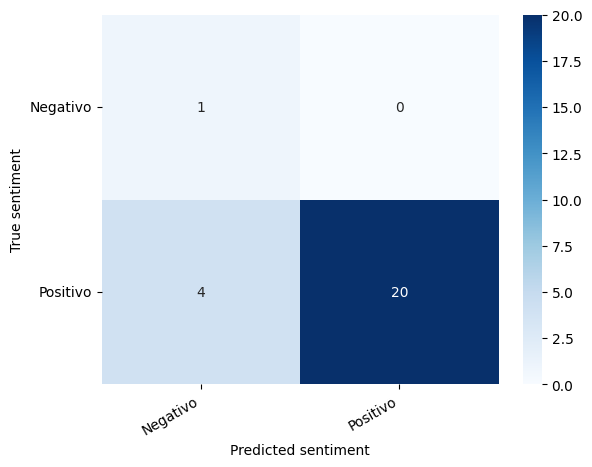

In [15]:
cm = confusion_matrix(y_val, y_pred_val)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Criando e povoando o banco

In [16]:
import psycopg2
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    user="postgres",
    password="aluno",
    database="projeto_inova"
)

cursor = conn.cursor()

### messages

In [16]:
import psycopg2


conn = psycopg2.connect(
    host="localhost",
    port=5432,
    user="postgres",
    password="aluno",
    database="projeto_inova"
)
cur = conn.cursor()


cur.execute("""
    CREATE TABLE IF NOT EXISTS messages (
        id SERIAL PRIMARY KEY,
        contact_id INT NOT NULL,
        body TEXT,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
    );
""")


conn.commit()

cur.close()
conn.close()


### contacts

In [17]:
import psycopg2


conn = psycopg2.connect(
    host="localhost",
    port=5432,
    user="postgres",
    password="aluno",
    database="projeto_inova"
)
cur = conn.cursor()


cur.execute("""
    CREATE TABLE IF NOT EXISTS contacts (
        contact_id SERIAL PRIMARY KEY,
        phone VARCHAR(15),
        status INT DEFAULT 1
    );
""")


conn.commit()

cur.close()
conn.close()


### inserindo valores na contacts

In [67]:
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    user="postgres",
    password="aluno",
    database="projeto_inova"
)
cur = conn.cursor()

contacts_to_insert = [
    (35924643,'62998223865')
    #(20235323,'62998223366')
    # (32870421, '6299385566'),
    # (20671831, '6299385567')
]

cur.executemany("INSERT INTO contacts (contact_id, phone) VALUES (%s, %s);", contacts_to_insert)

conn.commit()

cur.close()
conn.close()


In [19]:
import pandas as pd
import psycopg2

conn = psycopg2.connect(
    host="localhost",
    port=5432,
    user="postgres",
    password="aluno",
    database="projeto_inova"
)

query = "SELECT * FROM contacts"
df = pd.read_sql(query, conn)

conn.close()

# Agora 'df' contém os dados da tabela 'messages'
print(df)


   contact_id       phone  status
0    20671831  6299385567       1
1    32870421  6299385566       0


C:\Users\heinr\AppData\Local\Temp\ipykernel_4036\1849902478.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


### inserindo valores na messages

In [35]:
# import pandas as pd
# import psycopg2

# # Supondo que o DataFrame já esteja carregado como df
# df = pd.read_csv(r"D:\Users\heinr\Desktop\TCC-Adriano\classsificação_bert\data_valid3.csv")
# # df = pd.read_csv(r"D:\Users\heinr\Desktop\TCC-Adriano\classsificação_bert\data_valid1.csv")

# # Conecte-se ao seu banco de dados PostgreSQL
# conn = psycopg2.connect(
#     host="localhost",
#     port=5432,
#     user="postgres",
#     password="aluno",
#     database="projeto_inova"
# )

# 
# cur = conn.cursor()

# # Insira as linhas do DataFrame na tabela 'messages'
# for index, row in df.iterrows():
#     cur.execute("""
#         INSERT INTO messages (contact_id, body, created_at)
#         VALUES (%s, %s, %s);
#     """, (row['contact_id'], row['body'], row['created_at']))

# 
# conn.commit()


# cur.close()
# conn.close()


In [36]:
import pandas as pd
import psycopg2

conn = psycopg2.connect(
    host="localhost",
    port=5432,
    user="postgres",
    password="aluno",
    database="projeto_inova"
)

query = "SELECT * FROM messages" # Ajuste a query de acordo com suas necessidades
df = pd.read_sql(query, conn)

# Feche a conexão
conn.close()

# Agora 'df' contém os dados da tabela 'messages'
print(df)


      id  contact_id  \
0      1    32870421   
1      2    32870421   
2      3    32870421   
3      4    32870421   
4      5    32870421   
..   ...         ...   
379  380    35924643   
380  381    35924643   
381  382    35924643   
382  383    35924643   
383  384    35924643   

                                                                                                                                                                                                                                                                                              body  \
0                                                                                                                                                                                                                                                           Este contato foi editado em 07/02/2023   
1                                                                                                                          

C:\Users\heinr\AppData\Local\Temp\ipykernel_1916\3275511988.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


## Atualizando o banco

#### limpando o status

In [61]:
import pandas as pd
import psycopg2

# Conectando ao banco de dados
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    user="postgres",
    password="aluno",
    database="projeto_inova"
)
cur = conn.cursor()

# Lendo os dados da tabela 'messages' usando Pandas
cur.execute("UPDATE contacts SET status = 1;")
conn.commit()
# Feche a conexão
conn.close()

# Agora 'df' contém os dados da tabela 'messages'


In [62]:
import pandas as pd
import psycopg2

# Conectando ao banco de dados
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    user="postgres",
    password="aluno",
    database="projeto_inova"
)

# Lendo os dados da tabela 'messages' usando Pandas
query = "SELECT * FROM contacts" 
df = pd.read_sql(query, conn)

# Feche a conexão
conn.close()

# Agora 'df' contém os dados da tabela 'messages'
print(df)


   contact_id        phone  status
0    34507907  62998223865       1
1    32870421   6299385566       1
2    20671831   6299385567       1


C:\Users\heinr\AppData\Local\Temp\ipykernel_1916\403359127.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


#### atualizando status

In [94]:
import psycopg2

BATCH_SIZE = 16
MAX_LEN = 160

# Conecte-se ao banco de dados PostgreSQL
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    user="postgres",
    password="aluno",
    database="projeto_inova"
)
cur = conn.cursor()

# 1. Recupere todos os IDs únicos de contatos
cur.execute("SELECT DISTINCT contact_id FROM contacts;")
contact_ids = [row[0] for row in cur.fetchall()]

i = 0
# 2. Para cada ID de contato, recupere as 10 últimas mensagens
for contact_id in contact_ids:
    i += 1
    query = """
        SELECT body FROM messages
        WHERE contact_id = %s
        ORDER BY created_at DESC
        LIMIT 10;
    """
    cur.execute(query, (contact_id,))
    df = pd.read_sql(query, conn, params=(contact_id,))
    df.rename(columns={'body': 'review_text'}, inplace=True)
    df = codigos.preprocess.preprocess_text_stop(df)
    messages = [row[0] for row in cur.fetchall()]

    # Prepare o DataLoader com as 10 mensagens
    valid_data_loader = create_data_loader2(df, tokenizer, MAX_LEN, BATCH_SIZE)

    # 3. Avalie essas mensagens com seu modelo
    y_review_texts_val, y_pred_val, y_pred_probs_val, y_val = get_predictions(model, valid_data_loader)

    df['y_pred'] = y_pred_val
    pd.set_option('display.max_colwidth', None)
    print(df[['frase','y_pred']])
    match i:
        case 1:
            a = df
        case 2:
            b = df
        case 3:
            c = df

    # 4. Se pelo menos uma previsão for zero, atualize o status do contato
    if any(pred == 0 for pred in y_pred_val):
        cur.execute("UPDATE contacts SET status = 0 WHERE contact_id = %s;", (contact_id,))
    else:
        cur.execute("UPDATE contacts SET status = 1 WHERE contact_id = %s;", (contact_id,))

# Confirme as alterações
conn.commit()

# Feche o cursor e a conexão
cur.close()
conn.close()

C:\Users\heinr\AppData\Local\Temp\ipykernel_1916\3304194655.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=(contact_id,))
d:\Users\heinr\anaconda3\envs\tccamb\Lib\site-packages\transformers\tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
C:\Users\heinr\AppData\Local\Temp\ipykernel_1916\3304194655.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/con

                                                                                                                                frase  \
0                                                                                                                     contato editado   
1                                                                                                 certo vou preparar carrinho compras   
3                                                                                                     vitor diz nao responda mensagem   
4                                                                                                 vitor diz dinheiro comprar cadeiras   
5                                                                                                                        vitor diz oi   
6                                                                                                 contato redirecionado vitor sistema   
7                                        

C:\Users\heinr\AppData\Local\Temp\ipykernel_1916\3304194655.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=(contact_id,))
d:\Users\heinr\anaconda3\envs\tccamb\Lib\site-packages\transformers\tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


                                                                                                                                                                       frase  \
0  body bom dia nando tudo bem voce entrando contato confirmar reuniao prevista dia hoje posso confirmar header type none text mediaurl footer button category language name   
1                                                                                                                                                            contato editado   
2                                                                                                                      kennedy moreira diz maravilha nando encaminhei invite   
3                                                                                                                                                                         ok   
4                                                                                                                       

In [87]:
b.columns

Index(['review_text', 'texto_processado', 'frase', 'y_pred'], dtype='object')

In [96]:
c[['review_text','y_pred']]

,review_text,y_pred
0,"{""body"":""Bom dia Nando , tudo bem com você Estou entrando em contato para confirmar nossa reunião prevista para o dia de hoje. Posso confirmar "",""header"":{""type"":""none"",""text"":"""",""mediaUrl"":""""},""footer"":"""",""buttons"":[],""category"":1,""language"":46,""name"":""polichat_quick_message_359030""}",1
1,Este contato foi editado em 25/05/2023,1
2,"*Kennedy Moreira diz:*\n\nMaravilha Nando, te encaminhei o invite",1
3,ok,1
4,*Kennedy Moreira diz:*\n\nVou te enviar o invite da nossa reunião,1
5,*Kennedy Moreira diz:*\n\nBoa tarde Nando,1
6,Contato redirecionado para Kennedy Moreira por Renato Fonseca em 22/05/2023 às 15:31,1
7,*Renato Fonseca diz:*\n\nUm momento,1
8,Preciso falar com o Kenedy,1
9,Souza e Melo Consultoria Previdenciária,1


In [80]:
contact_ids

[32870421, 20671831, 35924643]

In [69]:
y_pred_val

tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0])

In [91]:
import pandas as pd
import psycopg2

# Conectando ao banco de dados
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    user="postgres",
    password="aluno",
    database="projeto_inova"
)


query = "SELECT * FROM contacts" 
df = pd.read_sql(query, conn)

# Feche a conexão
conn.close()

# Agora 'df' contém os dados da tabela 'contacts'
print(df)


   contact_id        phone  status
0    32870421   6299385566       0
1    20671831   6299385567       0
2    35924643  62998223865       1


C:\Users\heinr\AppData\Local\Temp\ipykernel_1916\1849902478.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
